In [1]:
import xarray as xr
import numpy as np
import scipy as sc
import sklearn as skl
import skimage as ski
from scipy.linalg import norm
from scipy.spatial.distance import euclidean, jensenshannon, correlation
from scipy.stats import wasserstein_distance, ecdf
import skgstat as skg
import pysteps
from pysteps.verification.spatialscores import fss
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

Pysteps configuration file found at: /work/FAC/FGSE/IDYST/tbeucler/default/mfeldman/miniforge3/envs/wb/lib/python3.11/site-packages/pysteps/pystepsrc



In [2]:
datapath='/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/MF_ML_PREDICT/'
models=['graphcast_','graphcast-oper','pangu_','pangu-oper','fcnv2_dawn','ifs']
references=['era','ifs_init']
figpath='/users/mfeldman/figs/'
c1='#648fff' #lightblue
c2='#785ef0' #indigo
c3='#dc267f' #magenta
c4='#fe6100' #orange
c5='#ffb000' #gold
c6='#000000' #black



graphcast_


KeyError: "No variable named ('cape', 'bs_06'). Variables on the dataset include ['du_01', 'dv_01', 'bs_01', 'du_03', 'dv_03', ..., 'lon', 'prediction_timedelta', 'time', 'level', 'mcape_mcin_lcl_lfc']"

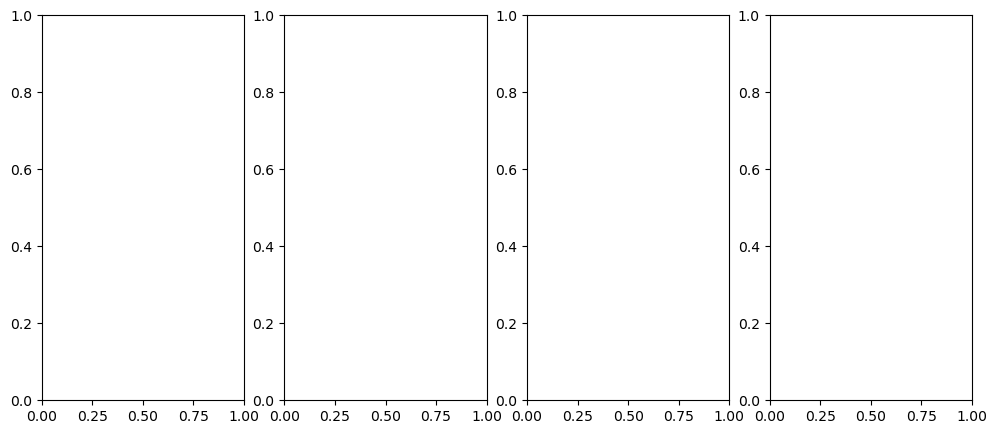

In [6]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
nn=0
mm=0
for mm in range(5):
    var=['cape','cin','bs_06','bs_03','bs_01'][mm]
    tit=['CAPE [J kg$^{-1}$]','CIN [J kg$^{-1}$]','0-6km shear [m s$^{-1}$]','0-3km shear [m s$^{-1}$]','0-1km shear [m s$^{-1}$]'][mm]
    l1=[300,-100,10,5,5][mm]
    l2=[1000,-300,20,10,10][mm]
    f1=[1,-1,1,1,1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,4,figsize=(12, 5))
    for nn in range(len(models)):
        kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        print(model)
        i=0
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'))
        fss_eval_300=np.zeros([len(files)+8+i,len(files)]); fss_eval_300[:]=np.nan
        fss_eval_1000=np.zeros([len(files)+8+i,len(files)]); fss_eval_1000[:]=np.nan
        rmse=np.zeros([len(files)+8+i,len(files)]); rmse[:]=np.nan
        bias=np.zeros([len(files)+8+i,len(files)]); bias[:]=np.nan
        for file in range(len(files)):
            #print(files[file])
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            for tstep in range(len(model_set[kw2])):
                
                fss_eval_300[tstep+file+i,file] = fss(f1*model_set[var].values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l1, scale=4)
                fss_eval_1000[tstep+file+i,file] = fss(f1*model_set.cape.values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l2, scale=4)
                
                rmse[tstep+file+i,file] = np.nanmean((model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])**2)**0.5
                
                bias[tstep+file+i,file] = np.nanmean(model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])
                
        color=[c1,c2,c3,c4,c5,c6][nn]

        
    
        
        # axes[0].plot(range(8+len(files)),fss_eval,c=color)
        # axes[1].plot(range(8+len(files)),rmse,c=color)
        # axes[2].plot(range(8+len(files)),bias,c=color)
    
        axes2[0].plot(np.arange(8+i+len(files))*12,np.nanmedian(fss_eval_300,axis=1),c=color,label=model)
        axes2[0].fill_between(np.arange(8+i+len(files))*12,np.nanmax(fss_eval_300,axis=1),np.nanmin(fss_eval_300,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('FSS '+str(l1))
        axes2[0].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[0].legend()
        axes2[1].plot(np.arange(8+i+len(files))*12,np.nanmedian(fss_eval_1000,axis=1),c=color,label=model)
        axes2[1].fill_between(np.arange(8+i+len(files))*12,np.nanmax(fss_eval_1000,axis=1),np.nanmin(fss_eval_1000,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('FSS '+str(l2))
        axes2[1].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[2].plot(np.arange(8+i+len(files))*12,np.nanmedian(rmse,axis=1),c=color)
        axes2[2].fill_between(np.arange(8+i+len(files))*12,np.nanmax(rmse,axis=1),np.nanmin(rmse,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('RMSE')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel(tit)
        axes2[3].plot(np.arange(8+i+len(files))*12,np.nanmedian(bias,axis=1),c=color)
        axes2[3].fill_between(np.arange(8+i+len(files))*12,np.nanmax(bias,axis=1),np.nanmin(bias,axis=1),facecolor=color,alpha=0.3)
        axes2[3].set_title('BIAS')
        axes2[3].set_xlabel('leadtime [h]')
        axes2[3].set_ylabel(tit)
        fig2.suptitle(tit)
    
        # axes2[0].boxplot(np.transpose(fss_eval),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[1].boxplot(np.transpose(rmse),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[2].boxplot(np.transpose(bias),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
    # fig.show()
    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_scores.png')
            
    # print(fss_eval)
    # print(rmse)
    # print(bias)

graphcast_
graphcast-oper
pangu_
pangu-oper
fcnv2_dawn
ifs


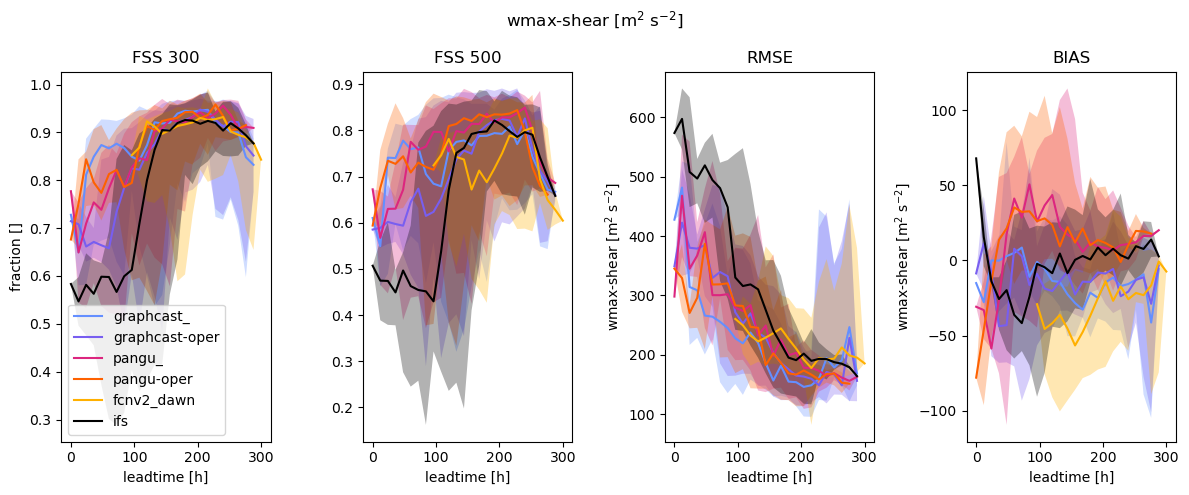

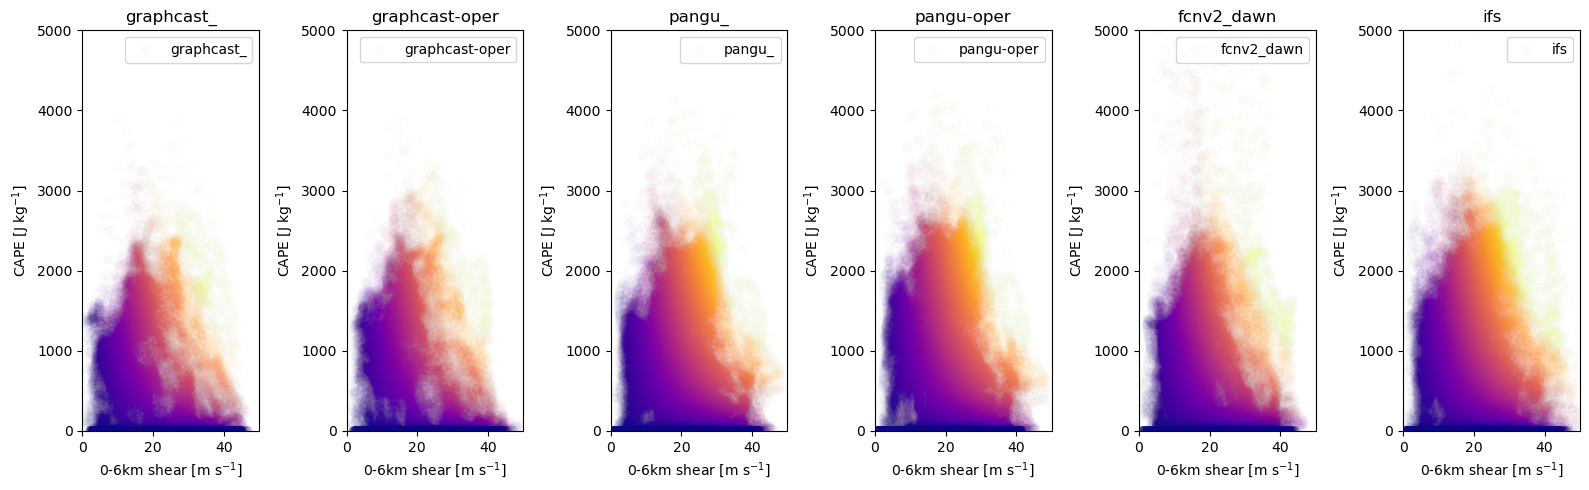

In [5]:
era_ref=xr.open_dataset(datapath+'USA_tor_2020_era.nc').sortby('latitude').fillna(0)
#era_ref=era_ref.assign(wms=lambda era_ref: (era_ref.cape*2)**0.5 * era_ref.bs_06 )
cape=era_ref.cape.squeeze().values
wms=(cape * 2)**0.5 * era_ref.bs_06
era_ref=era_ref.assign(wms=lambda era_ref: wms)
nn=0
mm=0
for mm in range(1):
    var=['wms'][mm]
    tit=['wmax-shear [m$^2$ s$^{-2}$]'][mm]
    l1=[300][mm]
    l2=[500][mm]
    f1=[1][mm]
    # fig,axes = plt.subplots(1,3)
    fig2,axes2 = plt.subplots(1,4,figsize=(12, 5))
    fig3,axes3 = plt.subplots(1,6,figsize=(16, 5))
    for nn in range(len(models)):
        kw=['lat','lat','latitude','latitude','latitude','latitude'][nn]
        kw2=['prediction_timedelta','prediction_timedelta','prediction_timedelta','prediction_timedelta','time','prediction_timedelta'][nn]
        model=models[nn]
        print(model)
        i=0
        if model=='fcnv2_dawn': i=8
        files=sorted(glob(datapath+'USA_tor_2020_'+model+'*2020*.nc'))
        fss_eval_300=np.zeros([len(files)+8+i,len(files)]); fss_eval_300[:]=np.nan
        fss_eval_1000=np.zeros([len(files)+8+i,len(files)]); fss_eval_1000[:]=np.nan
        rmse=np.zeros([len(files)+8+i,len(files)]); rmse[:]=np.nan
        bias=np.zeros([len(files)+8+i,len(files)]); bias[:]=np.nan
        for file in range(len(files)):
            #print(files[file])
            model_set=xr.open_dataset(files[file]).sortby(kw).fillna(0).squeeze()
            cape=model_set.cape.squeeze().values
            wms=(cape * 2)**0.5 * model_set.bs_06
            model_set=model_set.assign(wms=lambda model_set: wms )
            for tstep in range(len(model_set[kw2])):
                
                fss_eval_300[tstep+file+i,file] = fss(f1*model_set[var].values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l1, scale=4)
                fss_eval_1000[tstep+file+i,file] = fss(f1*model_set.cape.values[tstep,:,:], f1*era_ref[var].values[tstep,:,:], l2, scale=4)
                
                rmse[tstep+file+i,file] = np.nanmean((model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])**2)**0.5
                
                bias[tstep+file+i,file] = np.nanmean(model_set[var].values[tstep,:,:] - era_ref[var].values[tstep,:,:])
            
            # model_sb=model_set.to_pandas()

            # sns.kdeplot(data=model_sb, x="bs_06", y="cape", hue="prediction_timedelta")
                
        color=[c1,c2,c3,c4,c5,c6][nn]
    
        
        # axes[0].plot(range(8+len(files)),fss_eval,c=color)
        # axes[1].plot(range(8+len(files)),rmse,c=color)
        # axes[2].plot(range(8+len(files)),bias,c=color)
    
        axes2[0].plot(np.arange(8+i+len(files))*12,np.nanmedian(fss_eval_300,axis=1),c=color,label=model)
        axes2[0].fill_between(np.arange(8+i+len(files))*12,np.nanmax(fss_eval_300,axis=1),np.nanmin(fss_eval_300,axis=1),facecolor=color,alpha=0.3)
        axes2[0].set_title('FSS '+str(l1))
        axes2[0].set_xlabel('leadtime [h]')
        axes2[0].set_ylabel('fraction []')
        axes2[0].legend()
        axes2[1].plot(np.arange(8+i+len(files))*12,np.nanmedian(fss_eval_1000,axis=1),c=color,label=model)
        axes2[1].fill_between(np.arange(8+i+len(files))*12,np.nanmax(fss_eval_1000,axis=1),np.nanmin(fss_eval_1000,axis=1),facecolor=color,alpha=0.3)
        axes2[1].set_title('FSS '+str(l2))
        axes2[1].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel('fraction []')
        axes2[2].plot(np.arange(8+i+len(files))*12,np.nanmedian(rmse,axis=1),c=color)
        axes2[2].fill_between(np.arange(8+i+len(files))*12,np.nanmax(rmse,axis=1),np.nanmin(rmse,axis=1),facecolor=color,alpha=0.3)
        axes2[2].set_title('RMSE')
        axes2[2].set_xlabel('leadtime [h]')
        axes2[2].set_ylabel(tit)
        axes2[3].plot(np.arange(8+i+len(files))*12,np.nanmedian(bias,axis=1),c=color)
        axes2[3].fill_between(np.arange(8+i+len(files))*12,np.nanmax(bias,axis=1),np.nanmin(bias,axis=1),facecolor=color,alpha=0.3)
        axes2[3].set_title('BIAS')
        axes2[3].set_xlabel('leadtime [h]')
        axes2[3].set_ylabel(tit)
        fig2.suptitle(tit)

        axes3[nn].scatter(model_set.bs_06,model_set.cape,c=model_set.wms,cmap='plasma',alpha=0.01,label=model,vmin=0,vmax=2000)
        axes3[nn].legend()
        axes3[nn].set_title(model)
        axes3[nn].set_xlim([0,50])
        axes3[nn].set_ylim([0,5000])
        axes3[nn].set_xlabel('0-6km shear [m s$^{-1}$]')
        axes3[nn].set_ylabel('CAPE [J kg$^{-1}$]')

        
        
    
        # axes2[0].boxplot(np.transpose(fss_eval),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[1].boxplot(np.transpose(rmse),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
        # axes2[2].boxplot(np.transpose(bias),positions=np.arange(8+len(files))+0.2*nn-0.5,widths=0.1)
    # fig.show()
    fig2.tight_layout()
    fig2.show()
    fig2.savefig(figpath+var+'_scores.png')

    fig3.tight_layout()
    fig3.show()
    fig3.savefig(figpath+var+'_scatter.png')
            
    # print(fss_eval)
    # print(rmse)
    # print(bias)

![alt text](attachment:/users/mfeldman/figs/cape_scores.png "CAPE scores")


<img src="/users/mfeldman/figs/CAPE_scores.png" alt="CAPE scores" height="100"> 


<img src="/users/mfeldman/figs/cape_scores.png"> 

In [5]:

lat, lon =np.meshgrid(era_ref.latitude,era_ref.longitude)

lat=lat.flatten(); lon=lon.flatten(); cape=era_ref.cape.fillna(0).values[0,:,:].flatten()
print(lat.shape)
print(cape.shape)
coords=np.zeros([len(lat),2])
coords[:,0]=lon; coords[:,1]=lat
print(coords.shape)
V = skg.Variogram(coords, cape)
# #determine variogram range to obtain distance, where data is uncorrelated
[range, sill, nugget] = V.parameters

(24321,)
(24321,)
(24321, 2)


In [5]:
## https://gist.github.com/larsmans/3116927
_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64


def hellinger1(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2


def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2


def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [7]:
ecdf(sample)

pdf = derivative(ecdf)

jensenshannon(p, q, base=None, *, axis=0, keepdims=False)
# probability distribution -> requires ecdf and pdf

wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)
# probability distribution -> requires ecdf and pdf

correlation(u, v, w=None, centered=True)
#correlation distance

V = skg.Variogram(coords, values)
#determine variogram range to obtain distance, where data is uncorrelated
[range, sill, nugget] = V.parameters


fss(X_f, X_o, thr, scale=range)


SyntaxError: iterable argument unpacking follows keyword argument unpacking (1837290051.py, line 5)